# Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.2


# Load Dataset

In [ ]:
img_dir = '/content/drive/MyDrive/Object Detection'
data_list = os.listdir(img_dir)
data_list

['flower', 'dog', 'fruit', 'person', 'car', 'airplane', 'motorbike', 'cat']

In [ ]:
DATASET_PATH  = img_dir
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 1
FREEZE_LAYERS = 150  
LEARNING_RATE = 5e-5


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='nearest')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation"
                                                  )
class_dictionary = train_batches.class_indices
class_dictionary


Found 5407 images belonging to 7 classes.
Found 1349 images belonging to 7 classes.


{'car': 0,
 'cat': 1,
 'dog': 2,
 'flower': 3,
 'fruit': 4,
 'motorbike': 5,
 'person': 6}

# Build and Train Model

In [ ]:
net = MobileNetV2(include_top=False,
                            weights='imagenet',
                            input_tensor=None,
                            input_shape=(224,224,3))

x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)

output_layer = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)
net_final = Model(inputs=net.input, outputs=output_layer)

for layer in net_final.layers[:FREEZE_LAYERS]:
  layer.trainable = False

for layer in net_final.layers[FREEZE_LAYERS:]:
  layer.trainable = True

net_final.compile(optimizer=Adam(lr=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

print(net_final.summary())

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 lization)                                                                                        
                                                                                                  
 block_5_add (Add)              (None, 28, 28, 32)   0           ['block_4_add[0][0]',            
                                                                  'block_5_project_BN[0][0]']     
                                                                                                  
 block_6_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_5_add[0][0]']            
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_6_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_6_e

In [ ]:
#FIT MODEL
result = net_final.fit_generator(train_batches,
                        steps_per_epoch = np.ceil(len(train_batches) / BATCH_SIZE),
                        validation_data = valid_batches,
                        validation_steps = np.ceil(len(valid_batches) / BATCH_SIZE),
                        epochs = 5
                       )

   1/5407 [..............................] - ETA: 4:56 - loss: 0.0000e+00 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


5407/5407 [==============================] - 133s 25ms/step - loss: 0.0198 - accuracy: 0.9965 - val_loss: 0.1474 - val_accuracy: 0.9867


# Evaluation

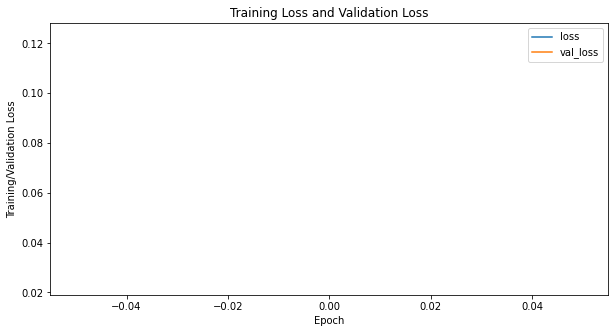

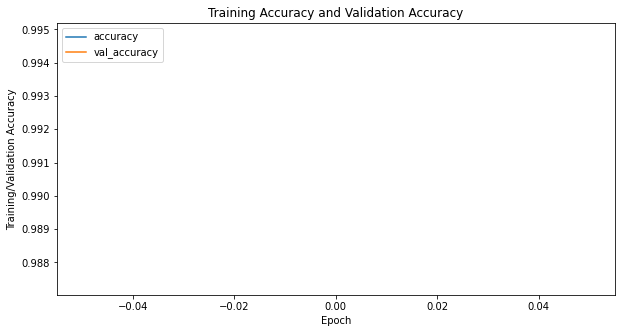

In [ ]:
# Plotting train_loss vs val_loss
plt.figure(figsize = (10, 5))
plt.plot(result.history["loss"], label = "loss")
plt.plot(result.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize = (10, 5))
plt.plot(result.history["accuracy"], label = "accuracy")
plt.plot(result.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = "upper left")

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

target_names = ['car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

predict = net_final.predict(valid_batches)
predict = np.argmax(predict, axis=1)

cm = confusion_matrix(valid_batches.classes, predict)
print(cm)

print("Classification Report")
print(classification_report(valid_batches.classes, predict, target_names = target_names))

[[193   0   0   0   0   0   0]
 [  0 173   4   0   0   0   0]
 [  0   3 137   0   0   0   0]
 [  0   0   4 164   0   0   0]
 [  0   0   1   0 199   0   0]
 [  0   0   0   0   0 157   0]
 [  0   0   1   9   0   0 304]]
Classification Report
              precision    recall  f1-score   support

         car       1.00      1.00      1.00       193
         cat       0.98      0.98      0.98       177
         dog       0.93      0.98      0.95       140
      flower       0.95      0.98      0.96       168
       fruit       1.00      0.99      1.00       200
   motorbike       1.00      1.00      1.00       157
      person       1.00      0.97      0.98       314

    accuracy                           0.98      1349
   macro avg       0.98      0.99      0.98      1349
weighted avg       0.98      0.98      0.98      1349



<function matplotlib.pyplot.show>

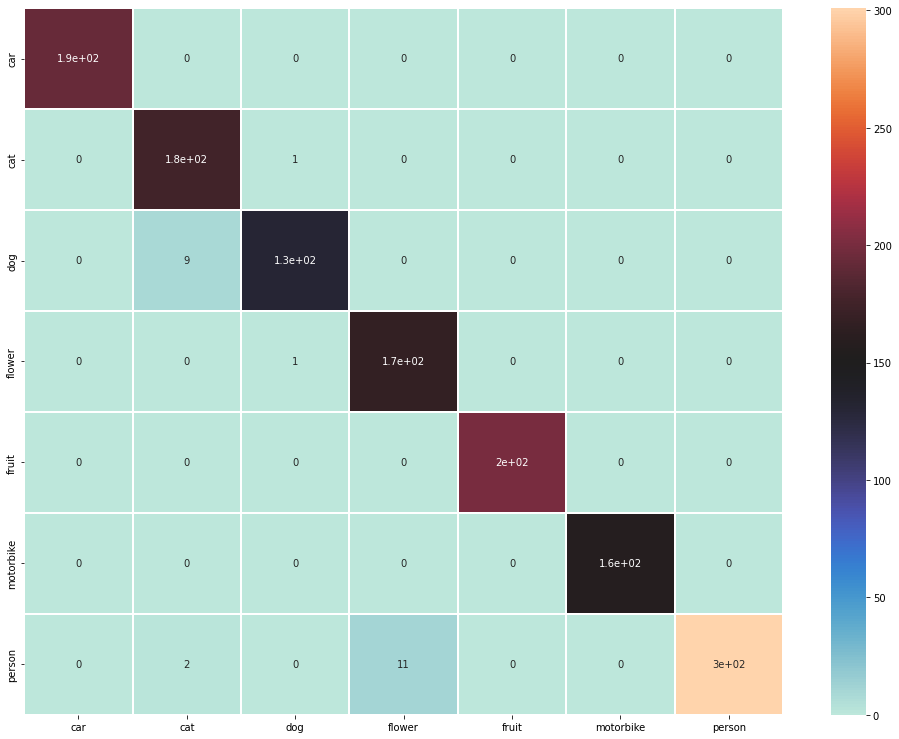

In [ ]:
plt.figure(figsize=(17, 13))
sns.heatmap(cm, cmap='icefire', annot=True, linewidths=1, xticklabels=target_names, yticklabels=target_names)
plt.show

# Save Model

In [ ]:
tf.keras.models.save_model(net_final, '/Object_model.h5')

In [ ]:
model = tf.keras.models.load_model(os.getcwd() + '/Object_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflmodel = converter.convert()
file = open('/Object_model.tflite' , 'wb' ) 
file.write(tflmodel)

INFO:tensorflow:Assets written to: /tmp/tmp_oj8lhsc/assets


10614784